In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import OrderedDict

# import data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import image utils
from PIL import Image
import cv2

# import image processing
import scipy.ndimage as ndi
import scipy

# import image utilities
from skimage.morphology import binary_opening, disk, label, binary_closing

# import image augmentation
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,GaussianBlur,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, PadIfNeeded, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform
)

# Import PyTorch
import torch
from torch import nn
from torch import optim
from torch.optim import Optimizer
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.autograd import Variable
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from torch.optim import lr_scheduler

import re
import math
import collections
from functools import partial

import math
import os

import time

from tqdm import tqdm_notebook

In [2]:
! ls ../input/aptos-2019-submissions/

ls: cannot access '../input/aptos-2019-submissions/': No such file or directory


Setup the environment:
* paths to folder with data
* load csv with data
* setup the transforms

In [2]:
TRAIN_PATH = './train_images/'
TEST_PATH = './test_images/'

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_transforms = Compose([HorizontalFlip(p=0.5),
                            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.2),
                            GaussianBlur(blur_limit=10, always_apply=True, p = 1.),
                            OneOf([RandomContrast(),
                                   RandomGamma(),
                                   RandomBrightness(),], p=0.3),
                            OneOf([ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                                   GridDistortion(),
                                   OpticalDistortion(distort_limit=2, shift_limit=0.5),], p=0.3)])

Seup the dataset:

In [3]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10, img_width = 299, img_height = 299):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (img_width, img_height))
    #image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

In [4]:
class AptosDataset(Dataset):
    '''
    The dataset for APTOS data.
    '''
    def __init__(self, dataset_path, df, transforms=None, size = (299, 299), mode = 'train', indices = None):
        self.dataset_path = dataset_path
        self.df = df
        self.transforms = transforms
        self.size = size
        self.mode = mode
        self.indices = list(range(len(df))) \
            if indices is None else indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        # open image and label
        idx = self.indices[idx]
        id_code = self.df.loc[idx]['id_code']
        image = Image.open(os.path.join(self.dataset_path, str(id_code) + '.png'))
        
        if self.mode == 'train' or self.mode == 'test':
            label = self.df.loc[idx]['diagnosis']
        else:
            label = None
        
        image = preprocess_image(np.asarray(image), self.size[0], self.size[1])
        
        # augment image
        if self.mode == 'train':
            augmented = self.transforms(image=np.array(image))
            image = Image.fromarray(augmented['image'], 'RGB')
        else:
            image = Image.fromarray(image, 'RGB')
        
        # normalize and convert to tensor
        tf = transforms.Compose([transforms.Resize(self.size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.500, 0.500, 0.500], std=[0.500, 0.500, 0.500])])
        image = tf(image)
        
        # in validation mode return image and id_code
        if self.mode == 'validation':
            return image, id_code

        # return tensor with image and label
        return image, label
    
    def get_label(self, idx):
        if not self.mode == 'validation' :
            idx = self.indices[idx]
            label = self.df.loc[idx]['diagnosis']
        else:
            return None

In [5]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.get_label(idx)
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [6]:
# weighted kappa metric

from sklearn.metrics import cohen_kappa_score

def kappa_metric(label, pred):
    pred = np.argmax(pred, axis = 1)
    return cohen_kappa_score(label, pred, weights = 'quadratic')

In [7]:
########################################################################
############### HELPERS FUNCTIONS FOR MODEL ARCHITECTURE ###############
########################################################################


# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])


# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])


# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


def relu_fn(x):
    """ Swish activation function """
    return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)

class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]]*2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""
    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self,):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.
        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.
        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params

class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above
    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = relu_fn(self._bn0(self._expand_conv(inputs)))
        x = relu_fn(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(relu_fn(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks
    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._dropout = self._global_params.dropout_rate
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = relu_fn(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = relu_fn(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """

        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        if self._dropout:
            x = F.dropout(x, p=self._dropout, training=self.training)
        x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return EfficientNet(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = EfficientNet.from_name(model_name, override_params={'num_classes': num_classes})
        
        model.load_state_dict(torch.load('efficientnet-b5-b6417697.pth'))
        
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet_b'+str(i) for i in range(num_models)]
        if model_name.replace('-','_') not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

In [8]:
# initialize pretrained XceptionNet with imagenet weights
efficientnetb5_model = EfficientNet.from_pretrained('efficientnet-b5')

In [9]:
# wrap up pretrained XceptionNet with new fc layer
class APTOSXception(nn.Module):

    def __init__(self, efficientnetb5_model, dropout = 0.3):
        super(APTOSXception, self).__init__()
        self.efficientnetb5_model = efficientnetb5_model
        
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(1000, 64)),
            ('bn1', nn.BatchNorm1d(num_features=64)),
            ('relu1', nn.ReLU(inplace=True)),
            ('logits', nn.Linear(64, 5))]))
    
    def forward(self, input):
        x = self.efficientnetb5_model(input)
        x = nn.ReLU(inplace=True)(x)
        x = self.classifier(x)
        
        return x

In [10]:
# initialize the model
dropout = 0.3
model = APTOSXception(efficientnetb5_model, dropout = dropout)

In [11]:
# setup training device
device = torch.device('cuda:1' if torch.cuda.is_available() else "cpu")

In [12]:
# define hyperparameters
test_split = 0.2
batch_size = 8
epochs = 20
learning_rate = 0.0001
num_workers = 1
image_size = 456

In [13]:
# create dataset and data loaders
dataset_size = len(train)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_ds = AptosDataset(TRAIN_PATH, train, transforms=train_transforms, size = (image_size, image_size), mode = 'train', indices = train_indices)
test_ds = AptosDataset(TRAIN_PATH, train, transforms=None, size = (image_size, image_size), mode = 'test', indices = test_indices)

train_sampler = ImbalancedDatasetSampler(train_ds)
test_sampler = ImbalancedDatasetSampler(test_ds)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

In [14]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [16]:
# load model pretrained on 2015 aptos data
checkpoint = torch.load("EfficentNetB5_2015.pth")
model.load_state_dict(checkpoint['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [15]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
for param in model.efficientnetb5_model.parameters():
    param.requires_grad = True
optimizer = RAdam(model.parameters(), lr=learning_rate)

train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy', 'Kappa train', 'Kappa test']) 

In [18]:
def train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats):
    #train the model
    model.to(device)
    
    # learning rate cosine annealing
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, len(trainloader), eta_min=0.000001)

    steps = 0
    running_loss = 0
    max_kappa = 0
    
    for epoch in range(epochs):

        since = time.time()

        train_accuracy = 0
        top3_train_accuracy = 0 
        kappa_train = 0
        
        for inputs, labels in tqdm_notebook(trainloader):
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # calculate train top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Calculate train top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
            
            # Calculate train weighted kappa metric
            kappa = kappa_metric(labels.cpu().numpy(), ps.detach().cpu().numpy())
            if kappa == np.nan:
                kappa = 0
            kappa_train += kappa

        time_elapsed = time.time() - since

        test_loss = 0
        test_accuracy = 0
        top3_test_accuracy = 0
        kappa_test = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                # Calculate test top-1 accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Calculate test top-3 accuracy
                np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
                target_numpy = labels.cpu().numpy()
                top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
                
                # Calculate test weighted kappa metric
                kappa = kappa_metric(labels.cpu().numpy(), ps.detach().cpu().numpy())
                if kappa == np.nan:
                    kappa = 0
                kappa_test += kappa
                
                if kappa_test > max_kappa:
                    checkpoint = {'state_dict': model.state_dict()}
                    torch.save(checkpoint, 'EfficentNetB5_pretrained_on_2015_'+ str(epoch) +'.pth')
                    max_kappa = kappa_test

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Time per epoch: {time_elapsed:.4f}.. "
              f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
              f"Train loss: {running_loss/len(trainloader):.4f}.. "
              f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
              f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
              f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
              f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}.. "
              f"Weighed kappa test: {kappa_test/len(testloader):.4f}.. "
              f"Weighed kappa train: {kappa_train/len(trainloader):.4f}.. ")

        train_stats = train_stats.append({'Epoch': epoch + 1, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader), 'Kappa train':kappa_train/len(trainloader), 'Kappa test':kappa_test/len(testloader)}, ignore_index=True)

        running_loss = 0
        model.train()
        scheduler.step()
        
    return model, train_stats

In [19]:
# train the model
model, train_stats = train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)



Epoch 1/20.. Time per epoch: 657.6432.. Average time per step: 1.7919.. Train loss: 0.8743.. Train accuracy: 0.7582.. Top-3 train accuracy: 0.9435.. Test loss: 0.4911.. Test accuracy: 0.8356.. Top-3 test accuracy: 0.9742.. Weighed kappa test: nan.. Weighed kappa train: nan.. 



Epoch 2/20.. Time per epoch: 642.4906.. Average time per step: 1.7507.. Train loss: 0.5649.. Train accuracy: 0.8130.. Top-3 train accuracy: 0.9670.. Test loss: 0.4726.. Test accuracy: 0.8274.. Top-3 test accuracy: 0.9837.. Weighed kappa test: 0.8745.. Weighed kappa train: 0.8687.. 



Epoch 3/20.. Time per epoch: 661.1947.. Average time per step: 1.8016.. Train loss: 0.5000.. Train accuracy: 0.8212.. Top-3 train accuracy: 0.9792.. Test loss: 0.4518.. Test accuracy: 0.8383.. Top-3 test accuracy: 0.9851.. Weighed kappa test: 0.8842.. Weighed kappa train: nan.. 



Epoch 4/20.. Time per epoch: 675.6903.. Average time per step: 1.8411.. Train loss: 0.4370.. Train accuracy: 0.8525.. Top-3 train accuracy: 0.9867.. Test loss: 0.4591.. Test accuracy: 0.8410.. Top-3 test accuracy: 0.9769.. Weighed kappa test: nan.. Weighed kappa train: nan.. 



Epoch 5/20.. Time per epoch: 648.8367.. Average time per step: 1.7679.. Train loss: 0.3797.. Train accuracy: 0.8689.. Top-3 train accuracy: 0.9888.. Test loss: 0.4123.. Test accuracy: 0.8492.. Top-3 test accuracy: 0.9837.. Weighed kappa test: 0.9015.. Weighed kappa train: nan.. 



Epoch 6/20.. Time per epoch: 667.1914.. Average time per step: 1.8180.. Train loss: 0.3419.. Train accuracy: 0.8873.. Top-3 train accuracy: 0.9922.. Test loss: 0.4469.. Test accuracy: 0.8519.. Top-3 test accuracy: 0.9823.. Weighed kappa test: nan.. Weighed kappa train: nan.. 



Epoch 7/20.. Time per epoch: 662.4467.. Average time per step: 1.8050.. Train loss: 0.2992.. Train accuracy: 0.9063.. Top-3 train accuracy: 0.9956.. Test loss: 0.5199.. Test accuracy: 0.8288.. Top-3 test accuracy: 0.9769.. Weighed kappa test: 0.8694.. Weighed kappa train: nan.. 



Epoch 8/20.. Time per epoch: 644.6056.. Average time per step: 1.7564.. Train loss: 0.2612.. Train accuracy: 0.9166.. Top-3 train accuracy: 0.9946.. Test loss: 0.6120.. Test accuracy: 0.8465.. Top-3 test accuracy: 0.9511.. Weighed kappa test: 0.8787.. Weighed kappa train: nan.. 



Epoch 9/20.. Time per epoch: 659.9792.. Average time per step: 1.7983.. Train loss: 0.2556.. Train accuracy: 0.9172.. Top-3 train accuracy: 0.9925.. Test loss: 0.5010.. Test accuracy: 0.8410.. Top-3 test accuracy: 0.9864.. Weighed kappa test: 0.8989.. Weighed kappa train: nan.. 



Epoch 10/20.. Time per epoch: 626.1357.. Average time per step: 1.7061.. Train loss: 0.1834.. Train accuracy: 0.9384.. Top-3 train accuracy: 0.9966.. Test loss: 0.6494.. Test accuracy: 0.7948.. Top-3 test accuracy: 0.9796.. Weighed kappa test: 0.8700.. Weighed kappa train: nan.. 



Epoch 11/20.. Time per epoch: 659.0064.. Average time per step: 1.7957.. Train loss: 0.1652.. Train accuracy: 0.9469.. Top-3 train accuracy: 0.9959.. Test loss: 0.5385.. Test accuracy: 0.8560.. Top-3 test accuracy: 0.9688.. Weighed kappa test: nan.. Weighed kappa train: nan.. 



Epoch 12/20.. Time per epoch: 668.3859.. Average time per step: 1.8212.. Train loss: 0.1456.. Train accuracy: 0.9574.. Top-3 train accuracy: 0.9976.. Test loss: 0.5172.. Test accuracy: 0.8533.. Top-3 test accuracy: 0.9823.. Weighed kappa test: 0.8971.. Weighed kappa train: nan.. 



Epoch 13/20.. Time per epoch: 655.8232.. Average time per step: 1.7870.. Train loss: 0.1679.. Train accuracy: 0.9506.. Top-3 train accuracy: 0.9963.. Test loss: 0.6689.. Test accuracy: 0.8234.. Top-3 test accuracy: 0.9742.. Weighed kappa test: 0.8867.. Weighed kappa train: nan.. 



Epoch 14/20.. Time per epoch: 670.3931.. Average time per step: 1.8267.. Train loss: 0.1485.. Train accuracy: 0.9574.. Top-3 train accuracy: 0.9986.. Test loss: 0.4946.. Test accuracy: 0.8696.. Top-3 test accuracy: 0.9810.. Weighed kappa test: 0.8936.. Weighed kappa train: nan.. 



Epoch 15/20.. Time per epoch: 638.2453.. Average time per step: 1.7391.. Train loss: 0.1629.. Train accuracy: 0.9533.. Top-3 train accuracy: 0.9980.. Test loss: 0.5849.. Test accuracy: 0.8220.. Top-3 test accuracy: 0.9769.. Weighed kappa test: 0.8641.. Weighed kappa train: nan.. 



Epoch 16/20.. Time per epoch: 678.5344.. Average time per step: 1.8489.. Train loss: 0.1260.. Train accuracy: 0.9601.. Top-3 train accuracy: 0.9983.. Test loss: 0.5739.. Test accuracy: 0.8533.. Top-3 test accuracy: 0.9837.. Weighed kappa test: 0.9071.. Weighed kappa train: nan.. 



Epoch 17/20.. Time per epoch: 657.9563.. Average time per step: 1.7928.. Train loss: 0.1145.. Train accuracy: 0.9680.. Top-3 train accuracy: 0.9986.. Test loss: 0.5345.. Test accuracy: 0.8601.. Top-3 test accuracy: 0.9728.. Weighed kappa test: nan.. Weighed kappa train: nan.. 



Epoch 18/20.. Time per epoch: 669.6773.. Average time per step: 1.8247.. Train loss: 0.1171.. Train accuracy: 0.9683.. Top-3 train accuracy: 0.9976.. Test loss: 0.6705.. Test accuracy: 0.8410.. Top-3 test accuracy: 0.9742.. Weighed kappa test: 0.8938.. Weighed kappa train: nan.. 



Epoch 19/20.. Time per epoch: 610.6638.. Average time per step: 1.6639.. Train loss: 0.1215.. Train accuracy: 0.9632.. Top-3 train accuracy: 0.9980.. Test loss: 0.5439.. Test accuracy: 0.8614.. Top-3 test accuracy: 0.9796.. Weighed kappa test: 0.9101.. Weighed kappa train: 0.9728.. 



Epoch 20/20.. Time per epoch: 639.3862.. Average time per step: 1.7422.. Train loss: 0.0949.. Train accuracy: 0.9721.. Top-3 train accuracy: 0.9983.. Test loss: 0.7162.. Test accuracy: 0.8247.. Top-3 test accuracy: 0.9796.. Weighed kappa test: 0.8932.. Weighed kappa train: nan.. 


In [20]:
# view training stats
train_stats.head()

,Epoch,Time per epoch,Avg time per step,Train loss,Train accuracy,Train top-3 accuracy,Test loss,Test accuracy,Test top-3 accuracy,Kappa train,Kappa test
0,1.0,657.643170,1.791943,0.874322,0.758174,0.943460,0.491088,0.835598,0.974185,NaN,NaN
1,2.0,642.490557,1.750655,0.564858,0.813011,0.966962,0.472558,0.827446,0.983696,0.868738,0.874537
2,3.0,661.194705,1.801620,0.500024,0.821185,0.979223,0.451769,0.838315,0.985054,NaN,0.884222
3,4.0,675.690295,1.841118,0.437042,0.852520,0.986717,0.459110,0.841033,0.976902,NaN,NaN
4,5.0,648.836663,1.767947,0.379667,0.868869,0.988760,0.412350,0.849185,0.983696,NaN,0.901480


validate the model:

In [18]:
valid_ds = AptosDataset(TEST_PATH, test, transforms=None, size = (image_size, image_size), mode = 'validation')
validloader = torch.utils.data.DataLoader(valid_ds, batch_size=1, num_workers=1)

In [22]:
model.eval()
#torch.cuda.empty_cache()

APTOSXception(
  (efficientnetb5_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
   

In [23]:
submission = {'id_code': [], 'diagnosis': []}

model.eval()
#torch.cuda.empty_cache()

for X, id_codes in tqdm_notebook(validloader):
    X = Variable(X).to(device)
    output = model(X)
    
    for i, id_code in enumerate(id_codes):
        top_p, top_class = output[i].topk(1)
        diagnosis = top_class.cpu().numpy()
        
        submission['id_code'].append(id_code)
        submission['diagnosis'].append(diagnosis[0])

In [24]:
submission_df = pd.DataFrame(submission, columns=['id_code', 'diagnosis'])
submission_df.to_csv('submission_pretrained_2015.csv', index=False)
submission_df.sample(10)

,id_code,diagnosis
662,5ab9e78b45ef,2
576,4f985a7320d9,2
1493,c7c003cdaaba,2
346,31d79157e7c4,2
1636,da807f93050c,2
908,7d353a9d3218,4
1656,dd525bbb2ca3,0
878,78bdd1ecee00,2
130,1326dad5651f,0
1498,c85bc4a45f7c,3


In [25]:
diagnosis_dict = {
    0:'No DR',
    1:'Mild',
    2:'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

In [26]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(10,20), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(list(diagnosis_dict.values()));
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


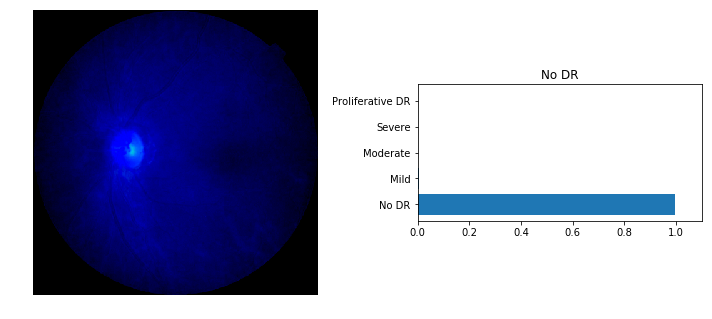

In [27]:
for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), diagnosis_dict[int(label_true.cpu().numpy())])
    
    break;

In [28]:
# save the model

checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, 'EfficentNetB5_pretrained_on_2015.pth')

In [29]:
# save training stats
train_stats.to_csv('EfficentNetB5_train_stats.csv', index=False)

In [30]:
train_stats.tail()

,Epoch,Time per epoch,Avg time per step,Train loss,Train accuracy,Train top-3 accuracy,Test loss,Test accuracy,Test top-3 accuracy,Kappa train,Kappa test
15,16.0,678.534449,1.848868,0.126025,0.960150,0.998297,0.573912,0.853261,0.983696,NaN,0.907093
16,17.0,657.956258,1.792796,0.114465,0.967984,0.998638,0.534484,0.860054,0.972826,NaN,NaN
17,18.0,669.677342,1.824734,0.117093,0.968324,0.997616,0.670487,0.841033,0.974185,NaN,0.893830
18,19.0,610.663783,1.663934,0.121499,0.963215,0.997956,0.543930,0.861413,0.979620,0.97282,0.910102
19,20.0,639.386216,1.742197,0.094930,0.972071,0.998297,0.716187,0.824728,0.979620,NaN,0.893234


Grid search over thresholds:

In [23]:
from functools import partial
import scipy as sp

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [38]:
def get_preds_and_labels(model, dataloader):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for x, lab in dataloader:
        x, lab = x.to(device), lab.to(device)
        
        logps = model(x)
        ps = torch.softmax(logps, dim = 1)
        
        top_p, top_class = ps.topk(1, dim=1)
        preds.append(top_p.cpu().detach().numpy())
        
        #print('-----')
        #print(ps)
        #print(top_p)
        
        labels.append(lab.cpu().detach().numpy())
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [40]:
# Calculate QWK on validation set
model.eval()
#torch.cuda.empty_cache()

y_val_preds, val_labels = get_preds_and_labels(model, testloader)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

RuntimeError: CUDA out of memory. Tried to allocate 78.00 MiB (GPU 1; 31.72 GiB total capacity; 29.89 GiB already allocated; 7.88 MiB free; 856.39 MiB cached)

In [28]:
# Optimize on validation data and evaluate again
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")

In [29]:
print(f"Optimized Thresholds:\n{coefficients}\n")
print(f"The Validation Quadratic Weighted Kappa (QWK)\n\
with optimized rounding thresholds is: {round(new_val_score, 5)}\n")
print(f"This is an improvement of {round(new_val_score - val_score, 5)}\n\
over the unoptimized rounding")

Optimized Thresholds:
[0.5 1.5 2.5 3.5]

The Validation Quadratic Weighted Kappa (QWK)
with optimized rounding thresholds is: 0.00098

This is an improvement of 0.0
over the unoptimized rounding


In [ ]:
# Make final predictions, round predictions and save to csv
y_test, _ = get_preds_and_labels(model, validloader)
y_test = optR.predict(y_test, coefficients).astype(np.uint8)
test_df['diagnosis'] = y_test
# Remove .png from ids
test_df['id_code'] = test_df['id_code'].str.replace(r'.png$', '')
test_df.to_csv('submission_effnetb5_optimized.csv', index=False)

In [19]:
checkpoint = torch.load("EfficentNetB5_pretrained_on_2015_18.pth")
model.load_state_dict(checkpoint['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [21]:
submission = {'id_code': [], 'diagnosis': []}

model.eval()
torch.cuda.empty_cache()

model = model.to(device)

for X, id_codes in tqdm_notebook(validloader):
    X = Variable(X).to(device)
    output = model(X)
    
    for i, id_code in enumerate(id_codes):
        top_p, top_class = output[i].topk(1)
        diagnosis = top_class.cpu().numpy()
        
        submission['id_code'].append(id_code)
        submission['diagnosis'].append(diagnosis[0])

In [22]:
submission_df = pd.DataFrame(submission, columns=['id_code', 'diagnosis'])
submission_df.to_csv('submission_pretrained_2015_max.csv', index=False)
submission_df.sample(10)

,id_code,diagnosis
662,5ab9e78b45ef,2
576,4f985a7320d9,2
1493,c7c003cdaaba,2
346,31d79157e7c4,2
1636,da807f93050c,4
908,7d353a9d3218,4
1656,dd525bbb2ca3,0
878,78bdd1ecee00,1
130,1326dad5651f,0
1498,c85bc4a45f7c,3
